**Прогнозирование рентабельности стартапов: анализ и моделирование**

**Заголовок:**
"Прогнозирование рентабельности стартапов: анализ и моделирование"

**Краткое описание:**
Данный проект направлен на создание моделей, способных прогнозировать рентабельность стартапов. Мы анализируем данные о стартапах, функционировавших с 1980 по 2018 годы, чтобы определить, какие из них закроются, а какие продолжат успешную деятельность. 

**План действий:**
1. **Загрузка и ознакомление с данными:**
   - Получение данных о стартапах.
   - Изучение структуры данных, оценка качества и целей проекта.

2. **Предварительная обработка:**
   - Обработка пропущенных значений.
   - Преобразование категориальных признаков.
   - Масштабирование числовых признаков.

3. **Разведочный анализ:**
   - Визуализация распределений признаков.
   - Исследование корреляций между признаками.

4. **Разработка новых синтетических признаков:**
   - Создание новых признаков на основе имеющихся данных.

5. **Проверка на мультиколлинеарность:**
   - Оценка мультиколлинеарности между признаками.

6. **Отбор финального набора обучающих признаков:**
   - Выбор наиболее значимых признаков для модели.

7. **Выбор и обучение моделей:**
   - Выбор алгоритмов машинного обучения.
   - Обучение моделей на обучающих данных.

8. **Итоговая оценка качества предсказания лучшей модели:**
   - Оценка точности и других метрик моделей.

9. **Анализ важности признаков:**
   - Определение влияния каждого признака на предсказание.

10. **Подготовка отчета по исследованию:**
    - Составление отчета с результатами и выводами.

Этот проект позволит нам лучше понять факторы, влияющие на успех стартапов. 🚀

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка и ознакомление с данными

                     name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2010-06-24       2011-05-01      2014-12-01  

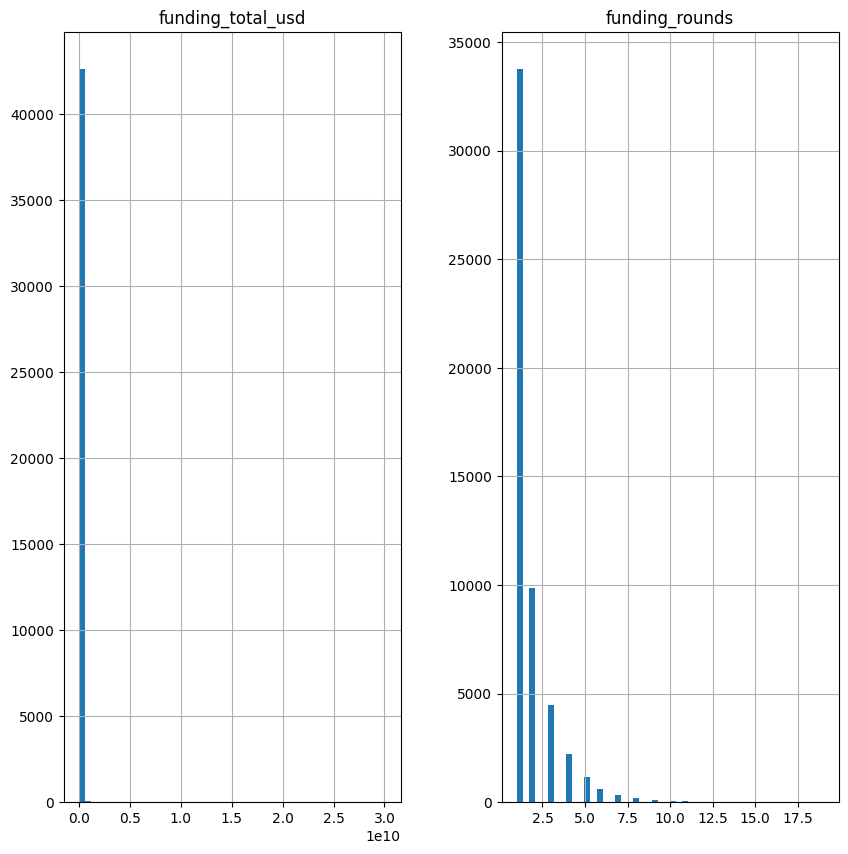

In [9]:
# Загрузка данных
df = pd.read_csv('kaggle_startups_train_01.csv')

# Просмотр первых 5 строк данных
print(df.head())

# Использование метода info
print(df.info())

# Основная статистика
print(df.describe())

# График распределения для каждого числового признака
df.hist(figsize=(10, 10), bins=50)
plt.show()

1. **Обзор данных**:
    - В таблице представлены стартапы с различными характеристиками.
    - Каждая строка соответствует отдельному стартапу.
    - Всего в данных **52879 записей**.

2. **Основные признаки**:
    - **name**: Название стартапа.
    - **category_list**: Категории, к которым относится стартап.
    - **funding_total_usd**: Общий объем финансирования в долларах США.
    - **status**: Статус стартапа (например, "operating", "closed").
    - **country_code**: Код страны.
    - **state_code**: Код штата (если применимо).
    - **region**: Регион, где находится стартап.
    - **city**: Город, где находится стартап.
    - **funding_rounds**: Количество раундов финансирования.
    - **founded_at**: Дата основания стартапа.
    - **first_funding_at**: Дата первого финансирования.
    - **last_funding_at**: Дата последнего финансирования.
    - **closed_at**: Дата закрытия (если применимо).

3. **Пропущенные значения**:
    - Некоторые признаки имеют пропущенные значения (например, **category_list**, **country_code**, **state_code**, **region**, **city**, **funding_total_usd**, **closed_at**).
    - Необходимо рассмотреть, как обрабатывать эти пропущенные значения.

4. **Статистика**:
    - Средний объем финансирования составляет **$18,930,590**.
    - Среднее количество раундов финансирования - **1.74**.

5. **График распределения**:
    - График показывает распределение числовых признаков.
    - Можно увидеть, какие значения преобладают и как они распределены.

**Вывод**: Данные содержат информацию о стартапах, и для дальнейшего анализа необходимо обратить внимание на пропущенные значения и провести более детальное исследование каждого признака. 🚀

# Предварительная обработка